In [3]:
import os
import copy
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import models
from sklearn.utils import shuffle
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.font_manager
from collections import OrderedDict

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

import os
print(os.getcwd())

C:\Users\Lokesh\Desktop\ML - 1ST PROJECT


In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dansbecker/food-101")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Lokesh\.cache\kagglehub\datasets\dansbecker\food-101\versions\1


In [9]:
classes = open("C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-101/meta/classes.txt", 'r').read().splitlines()
classes_21 = classes[:20] + ['other']
classes_21, len(classes_21)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheesecake',
  'cheese_plate',
  'chicken_curry',
  'chicken_quesadilla',
  'other'],
 21)

In [11]:
print("Testing images")
with open(r"C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-101/meta/test.txt", 'r') as file:
    for i in range(5):
        print(file.readline().strip())

print("\nTraining images")
with open(r"C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-101/meta/train.txt", 'r') as file:
    for i in range(5):
        print(file.readline().strip())

Testing images
apple_pie/1011328
apple_pie/101251
apple_pie/1034399
apple_pie/103801
apple_pie/1038694

Training images
apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283


In [13]:
def prep_df(path: str) -> pd.DataFrame:
    array = open(path, 'r').read().splitlines()

    # Getting the full path for the images
    img_path = "C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-101/images/"
    full_path = [img_path + img + ".jpg" for img in array]

    # Splitting the image index from the label
    imgs = []
    labels = []
    for img in array:
        img_split = img.split('/')
        labels.append(img_split[0])  # first part is the label
        imgs.append(img_split[1])    # second part is the image name

    # Converting the arrays to a DataFrame
    imgs_df = pd.DataFrame({
        'label': labels,
        'image_name': imgs,
        'path': full_path
    })

    # Randomly shuffling the data in the DataFrame
    imgs_df = shuffle(imgs_df)

    return imgs_df

In [15]:
train_imgs = prep_df('C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-101/meta/train.txt')
test_imgs = prep_df('C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-101/meta/test.txt')

train_imgs.head(5)

,label,image_name,path
4445,beet_salad,647999,C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-...
57683,pizza,790841,C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-...
15428,chicken_wings,2943589,C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-...
24509,dumplings,3474281,C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-...
60984,ramen,217449,C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-...


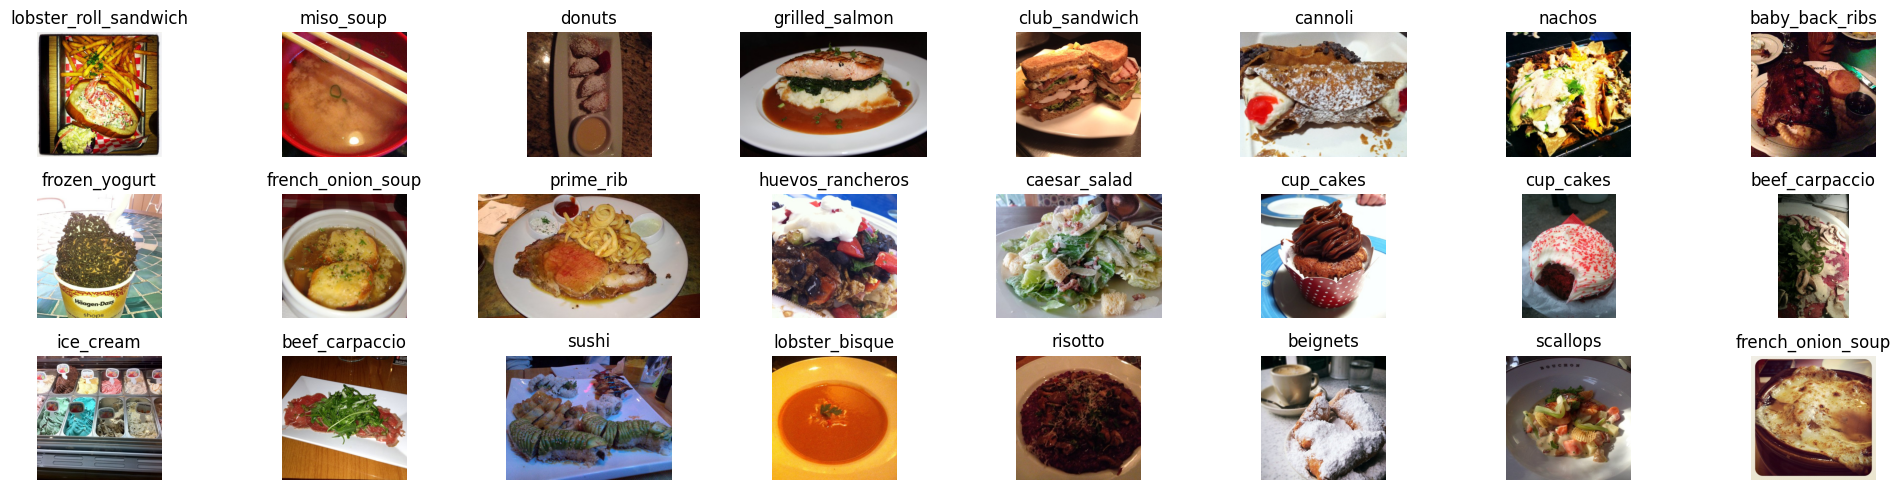

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

# Assuming train_imgs is your DataFrame from prep_df()
num_rows = 3
num_cols = 8

plt.figure(figsize=(20, 5))

for idx in range(num_rows * num_cols):
    random_idx = np.random.randint(0, train_imgs.shape[0])
    
    # Reading the image using plt.imread()
    img_path = train_imgs.path.iloc[random_idx]
    img = plt.imread(img_path)
    
    # Fetching the label
    label = train_imgs.label.iloc[random_idx]

    # Plotting the image
    ax = plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [19]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.IMAGENET),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
# Data augmentation for testing
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [21]:
class Label_encoder:
    def __init__(self, labels):
        labels = list(set(labels))
        self.labels = {label: idx for idx, label in enumerate(classes)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels[label]

encoder = Label_encoder(classes)
for i in range(20):
    print(encoder.get_label(i), encoder.get_idx( encoder.get_label(i) ))

apple_pie 0
baby_back_ribs 1
baklava 2
beef_carpaccio 3
beef_tartare 4
beet_salad 5
beignets 6
bibimbap 7
bread_pudding 8
breakfast_burrito 9
bruschetta 10
caesar_salad 11
cannoli 12
caprese_salad 13
carrot_cake 14
ceviche 15
cheesecake 16
cheese_plate 17
chicken_curry 18
chicken_quesadilla 19


In [23]:
class Food20(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_name = self.dataframe.path.iloc[idx]
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        label = encoder.get_idx(self.dataframe.label.iloc[idx])

        if self.transform:
            image = self.transform(image)

        return image, label

In [25]:
train_dataset = Food20(train_imgs, transform=train_transforms)
test_dataset = Food20(test_imgs, transform=test_transforms)

In [27]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [29]:
# Testing the retrieval of a single image
for i in range(10):
    image = train_dataset.__getitem__(i)
    print(encoder.get_label(image[1]), image[0].shape)

beet_salad torch.Size([3, 224, 224])
pizza torch.Size([3, 224, 224])
chicken_wings torch.Size([3, 224, 224])
dumplings torch.Size([3, 224, 224])
ramen torch.Size([3, 224, 224])
spaghetti_carbonara torch.Size([3, 224, 224])
fish_and_chips torch.Size([3, 224, 224])
spring_rolls torch.Size([3, 224, 224])
strawberry_shortcake torch.Size([3, 224, 224])
waffles torch.Size([3, 224, 224])


In [31]:
weights = models.DenseNet201_Weights.IMAGENET1K_V1
model = models.densenet201(weights = weights)

In [33]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [35]:
import requests as reqs

url = "https://github.com/Prakhar998/Food-Classification/raw/master/food_classifier.pt"  
r = reqs.get(url, allow_redirects=True)

open("./food_classifier.pt", "wb").write(r.content)

81841763

In [36]:
checkpoint_path = "./food_classifier.pt"
classifier = nn.Sequential(
    nn.Linear(1920,1024),
    nn.LeakyReLU(),
    nn.Linear(1024,101),
)

model.classifier = classifier
model.load_state_dict(torch.load(checkpoint_path,map_location='cpu'),strict=False)

model.to(device)

C:\Users\Lokesh\AppData\Local\Temp\ipykernel_14716\951729804.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path,map_locatio

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [39]:
#hyper parameters
num_epochs = 1

# loss
loss_fn = nn.CrossEntropyLoss()

# all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.999])

model = model.to(device)

In [41]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  print("--> Training Progress")
  # Loop through data loader data batches
  for batch, (X, y) in enumerate(tqdm(dataloader)):
      # Send data to target device
      images, labels = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(images)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, labels)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [43]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      print("--> Testing Progress")
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          # Send data to target device
          images, labels = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(images)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, labels)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)

          test_acc += ((test_pred_labels == labels).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [45]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device):
  # Create empty results dictionary
  history = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      'best train acc': (0, 0),
      "best_model": dict()
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in range(epochs):
      print('Epoch {}/{}'.format(epoch + 1, num_epochs))

      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
          f"\n\n=============================\n"
      )

      # Update results dictionary
      history["train_loss"].append(train_loss)
      history["train_acc"].append(train_acc)
      history["test_loss"].append(test_loss)
      history["test_acc"].append(test_acc)
      if test_loss < history["test_acc"][len(history["test_acc"]) - 1]:
          history["best_model"] = model.state_dict()

      if test_acc > 0.95:
         break

  # Return the filled results at the end of the epochs
  return model, history

In [45]:
def evaluate(model, dataloader):

  random = np.random.randint(0, len(dataloader))

  with torch.no_grad():
    model.eval()
    n_correct = 0
    n_samples = 0

    for images, labels in tqdm(dataloader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)

      preds = torch.argmax(torch.softmax(outputs, 1), 1)

      # Converting this problem to a problem with 21 clases only
      preds = np.array([pred.cpu() if pred < 20 else 20 for pred in preds])
      labels = np.array([label.cpu() if label < 20 else 20 for label in labels])

      n_samples += labels.shape[0]
      n_correct += (preds==labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(acc)

In [55]:
model, history = train(model, train_loader, test_loader, optimizer, loss_fn, num_epochs, device)

Epoch 1/1
--> Training Progress


100%|██████████████████████████████████████████████████████████████████████████████| 592/592 [2:55:14<00:00, 17.76s/it]


--> Testing Progress


100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [44:22<00:00, 13.45s/it]

Epoch: 1 | train_loss: 1.1151 | train_acc: 0.7127 | test_loss: 0.3151 | test_acc: 0.9093




In [47]:
def evaluate(model, dataloader):

  random = np.random.randint(0, len(dataloader))

  with torch.no_grad():
    model.eval()
    n_correct = 0
    n_samples = 0

    for images, labels in tqdm(dataloader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)

      preds = torch.argmax(torch.softmax(outputs, 1), 1)

      # Converting this problem to a problem with 21 clases only
      preds = np.array([pred.cpu() if pred < 20 else 20 for pred in preds])
      labels = np.array([label.cpu() if label < 20 else 20 for label in labels])

      n_samples += labels.shape[0]
      n_correct += (preds==labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(acc)

In [59]:
evaluate(model,test_loader)

100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [44:35<00:00, 13.51s/it]

96.55445544554455


In [49]:
class Label_encoder_21:
    def __init__(self, labels):
        labels = list(set(labels))
        self.labels = {label: idx for idx, label in enumerate(labels)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels[label]

encoder_21 = Label_encoder(classes_21)
encoder_21.get_label(0), encoder.get_idx( encoder_21.get_label(0) )

('apple_pie', 0)

In [51]:
#This line of code saves the best model's state dictionary (or parameters) from the training history to a file named solution.pth.
torch.save(history['best_model'], "C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-101/images/apple_pie/solution.pth")

NameError: name 'history' is not defined

In [73]:
import os

if os.path.exists("C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-101/images/apple_pie/solution.pth"):
    print("solution.pth exists in the current directory.")
else:
    print("solution.pth does not exist in the current directory.")

solution.pth exists in the current directory.


In [75]:
torch.save(model.state_dict(), 'saved_model.pth')

C:\Users\Lokesh\AppData\Local\Temp\ipykernel_15768\382434285.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

Loaded model from C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-101/images/apple_pie/solution.pth


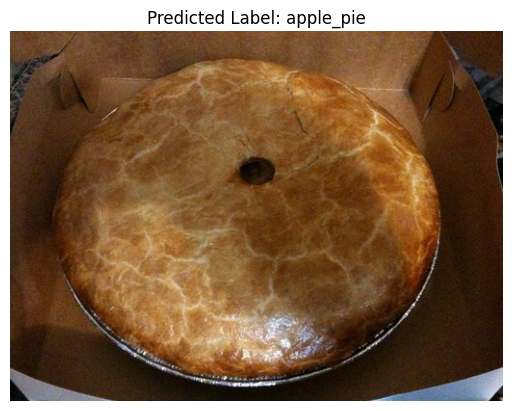

In [79]:
import torch
import os
from PIL import Image
from torchvision import transforms, models
import torch.nn as nn
import matplotlib.pyplot as plt

def classify_image(image_path, model, label_encoder, device):
    # Load and preprocess the input image
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Perform prediction
    with torch.no_grad():
        model.eval()
        output = model(image_tensor)

    # Get predicted class index
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()

    # Map index to class name
    predicted_label = label_encoder.get_label(predicted_idx)

    return predicted_label, image

# Load the saved model and label encoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet201(weights=None)
classifier = nn.Sequential(
    nn.Linear(1920, 1024),
    nn.LeakyReLU(),
    nn.Linear(1024, 101),
)
model.classifier = classifier

# Correct file path for loading model
model_path = "C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-101/images/apple_pie/solution.pth"

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Loaded model from {model_path}")
else:
    print(f"Model file not found at {model_path}")
    raise FileNotFoundError(f"No file found at {model_path}")

model.to(device)
model.eval()

# Assuming Label_encoder is a custom class handling label mapping
label_encoder = Label_encoder(classes)

# Classify an image and get the predicted label along with the image
image_path = "C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-101/images/apple_pie/23893.jpg"  # Replace with the path to your image
predicted_label, image = classify_image(image_path, model, label_encoder, device)

# Display the image and predicted label
plt.imshow(image)
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')  # Hide axes
plt.show()

C:\Users\Lokesh\AppData\Local\Temp\ipykernel_15768\2976304753.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=

Loaded model from C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-101/images/apple_pie/solution.pth


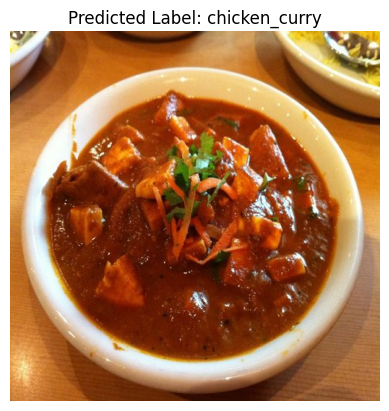

In [81]:
import torch
import os
from PIL import Image
from torchvision import transforms, models
import torch.nn as nn
import matplotlib.pyplot as plt

def classify_image(image_path, model, label_encoder, device):
    # Load and preprocess the input image
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Perform prediction
    with torch.no_grad():
        model.eval()
        output = model(image_tensor)

    # Get predicted class index
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()

    # Map index to class name
    predicted_label = label_encoder.get_label(predicted_idx)

    return predicted_label, image

# Load the saved model and label encoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet201(weights=None)
classifier = nn.Sequential(
    nn.Linear(1920, 1024),
    nn.LeakyReLU(),
    nn.Linear(1024, 101),
)
model.classifier = classifier

# Correct file path for loading model
model_path = "C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-101/images/apple_pie/solution.pth"

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Loaded model from {model_path}")
else:
    print(f"Model file not found at {model_path}")
    raise FileNotFoundError(f"No file found at {model_path}")

model.to(device)
model.eval()

# Assuming Label_encoder is a custom class handling label mapping
label_encoder = Label_encoder(classes)

# Classify an image and get the predicted label along with the image
image_path = "C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-101/images/chicken_curry/460508.jpg"  # Replace with the path to your image
predicted_label, image = classify_image(image_path, model, label_encoder, device)

# Display the image and predicted label
plt.imshow(image)
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')  # Hide axes
plt.show()

C:\Users\Lokesh\AppData\Local\Temp\ipykernel_14716\598244005.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

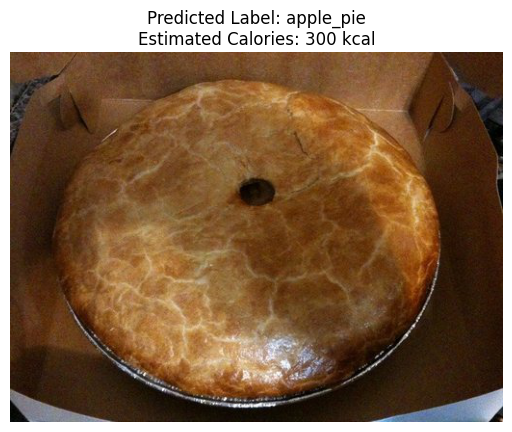

In [53]:
import torch
from PIL import Image
from torchvision import transforms, models
import torch.nn as nn
import matplotlib.pyplot as plt

def classify_image(image_path, model, label_encoder, device):
    # Load and preprocess the input image
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Perform prediction
    with torch.no_grad():
        model.eval()
        output = model(image_tensor)

    # Get predicted class index
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()

    # Map index to class name
    predicted_label = label_encoder.get_label(predicted_idx)

    return predicted_label, image

def get_calories(predicted_label):
    # A simple dictionary of food items and their estimated calorie values (kcal per serving)
    food_calories = {
        'apple_pie': 300,
        'chicken_curry': 450,
        'pizza': 270,
        'salad': 150,
        'burger': 500,
        'sushi': 200,
        # Add more food items and their approximate calorie content
    }
    
    return food_calories.get(predicted_label, "Calorie data not available")

# Load the saved model and label encoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet201(weights=None)
classifier = nn.Sequential(
    nn.Linear(1920, 1024),
    nn.LeakyReLU(),
    nn.Linear(1024, 101),
)
model.classifier = classifier

# Load model from file
model_path = "C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/solution path/solution.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Assuming Label_encoder is a custom class handling label mapping
label_encoder = Label_encoder(classes)

# Classify an image and get the predicted label along with the image
image_path = "C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-101/images/apple_pie/23893.jpg"  # Replace with the path to your image
predicted_label, image = classify_image(image_path, model, label_encoder, device)

# Get the estimated calories for the predicted label
calories = get_calories(predicted_label)

# Display the image, predicted label, and estimated calories
plt.imshow(image)
plt.title(f"Predicted Label: {predicted_label}\nEstimated Calories: {calories} kcal")
plt.axis('off')  # Hide axes
plt.show()


C:\Users\Lokesh\AppData\Local\Temp\ipykernel_14716\3412606727.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=

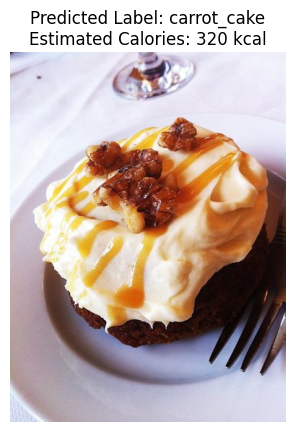

In [55]:
import torch
from PIL import Image
from torchvision import transforms, models
import torch.nn as nn
import matplotlib.pyplot as plt

def classify_image(image_path, model, label_encoder, device):
    # Load and preprocess the input image
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Perform prediction
    with torch.no_grad():
        model.eval()
        output = model(image_tensor)

    # Get predicted class index
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()

    # Map index to class name
    predicted_label = label_encoder.get_label(predicted_idx)

    return predicted_label, image

def get_calories(predicted_label):
    # A simple dictionary of food items and their estimated calorie values (kcal per serving)
    food_calories = {
        'apple_pie': 300,
        'baby_back_ribs': 500,
        'baklava': 350,
        'beef_carpaccio': 180,
        'beef_tartare': 220,
        'beet_salad': 150,
        'beignets': 250,
        'bibimbap': 600,
        'bread_pudding': 290,
        'breakfast_burrito': 400,
        'bruschetta': 170,
        'caesar_salad': 330,
        'cannoli': 230,
        'caprese_salad': 275,
        'carrot_cake': 320,
        'ceviche': 200,
        'cheesecake': 400,
        'cheese_plate': 450,
        'chicken_curry': 450,
        'chicken_quesadilla': 550,
       
    }
    
    return food_calories.get(predicted_label, "Calorie data not available")

# Load the saved model and label encoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet201(weights=None)
classifier = nn.Sequential(
    nn.Linear(1920, 1024),
    nn.LeakyReLU(),
    nn.Linear(1024, 101),
)
model.classifier = classifier

# Load model from file
model_path = "C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/solution path/solution.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Assuming Label_encoder is a custom class handling label mapping
label_encoder = Label_encoder(classes)

# Classify an image and get the predicted label along with the image
image_path = "C:/Users/Lokesh/Desktop/ML - 1ST PROJECT/food-101/images/carrot_cake/188437.jpg"  # Replace with the path to your image
predicted_label, image = classify_image(image_path, model, label_encoder, device)

# Get the estimated calories for the predicted label
calories = get_calories(predicted_label)

# Display the image, predicted label, and estimated calories
plt.imshow(image)
plt.title(f"Predicted Label: {predicted_label}\nEstimated Calories: {calories} kcal")
plt.axis('off')  # Hide axes
plt.show()